In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import DataLoader

In [2]:
# Dataset 
raw_data = load_boston()

data = raw_data.data
# label = raw_data.data

np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10

X_train = data[:trainset_size,:]
X_test = data[trainset_size:,:]

In [3]:
# Preprocessing 
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

In [4]:
# Models 
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z

        
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 5
LATENT_DIM = 5
BATCH_SIZE = 64
N_EPOCHS = 1000
lr = 1e-3
# weight_decay = 1e-2

In [6]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [7]:
avg_mu_x = torch.zeros(X_train.shape)

for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x
    mu_x = torch.zeros(mu_x.shape)
avg_mu_x /= 100
avg_mu_x.shape

torch.Size([354, 13])

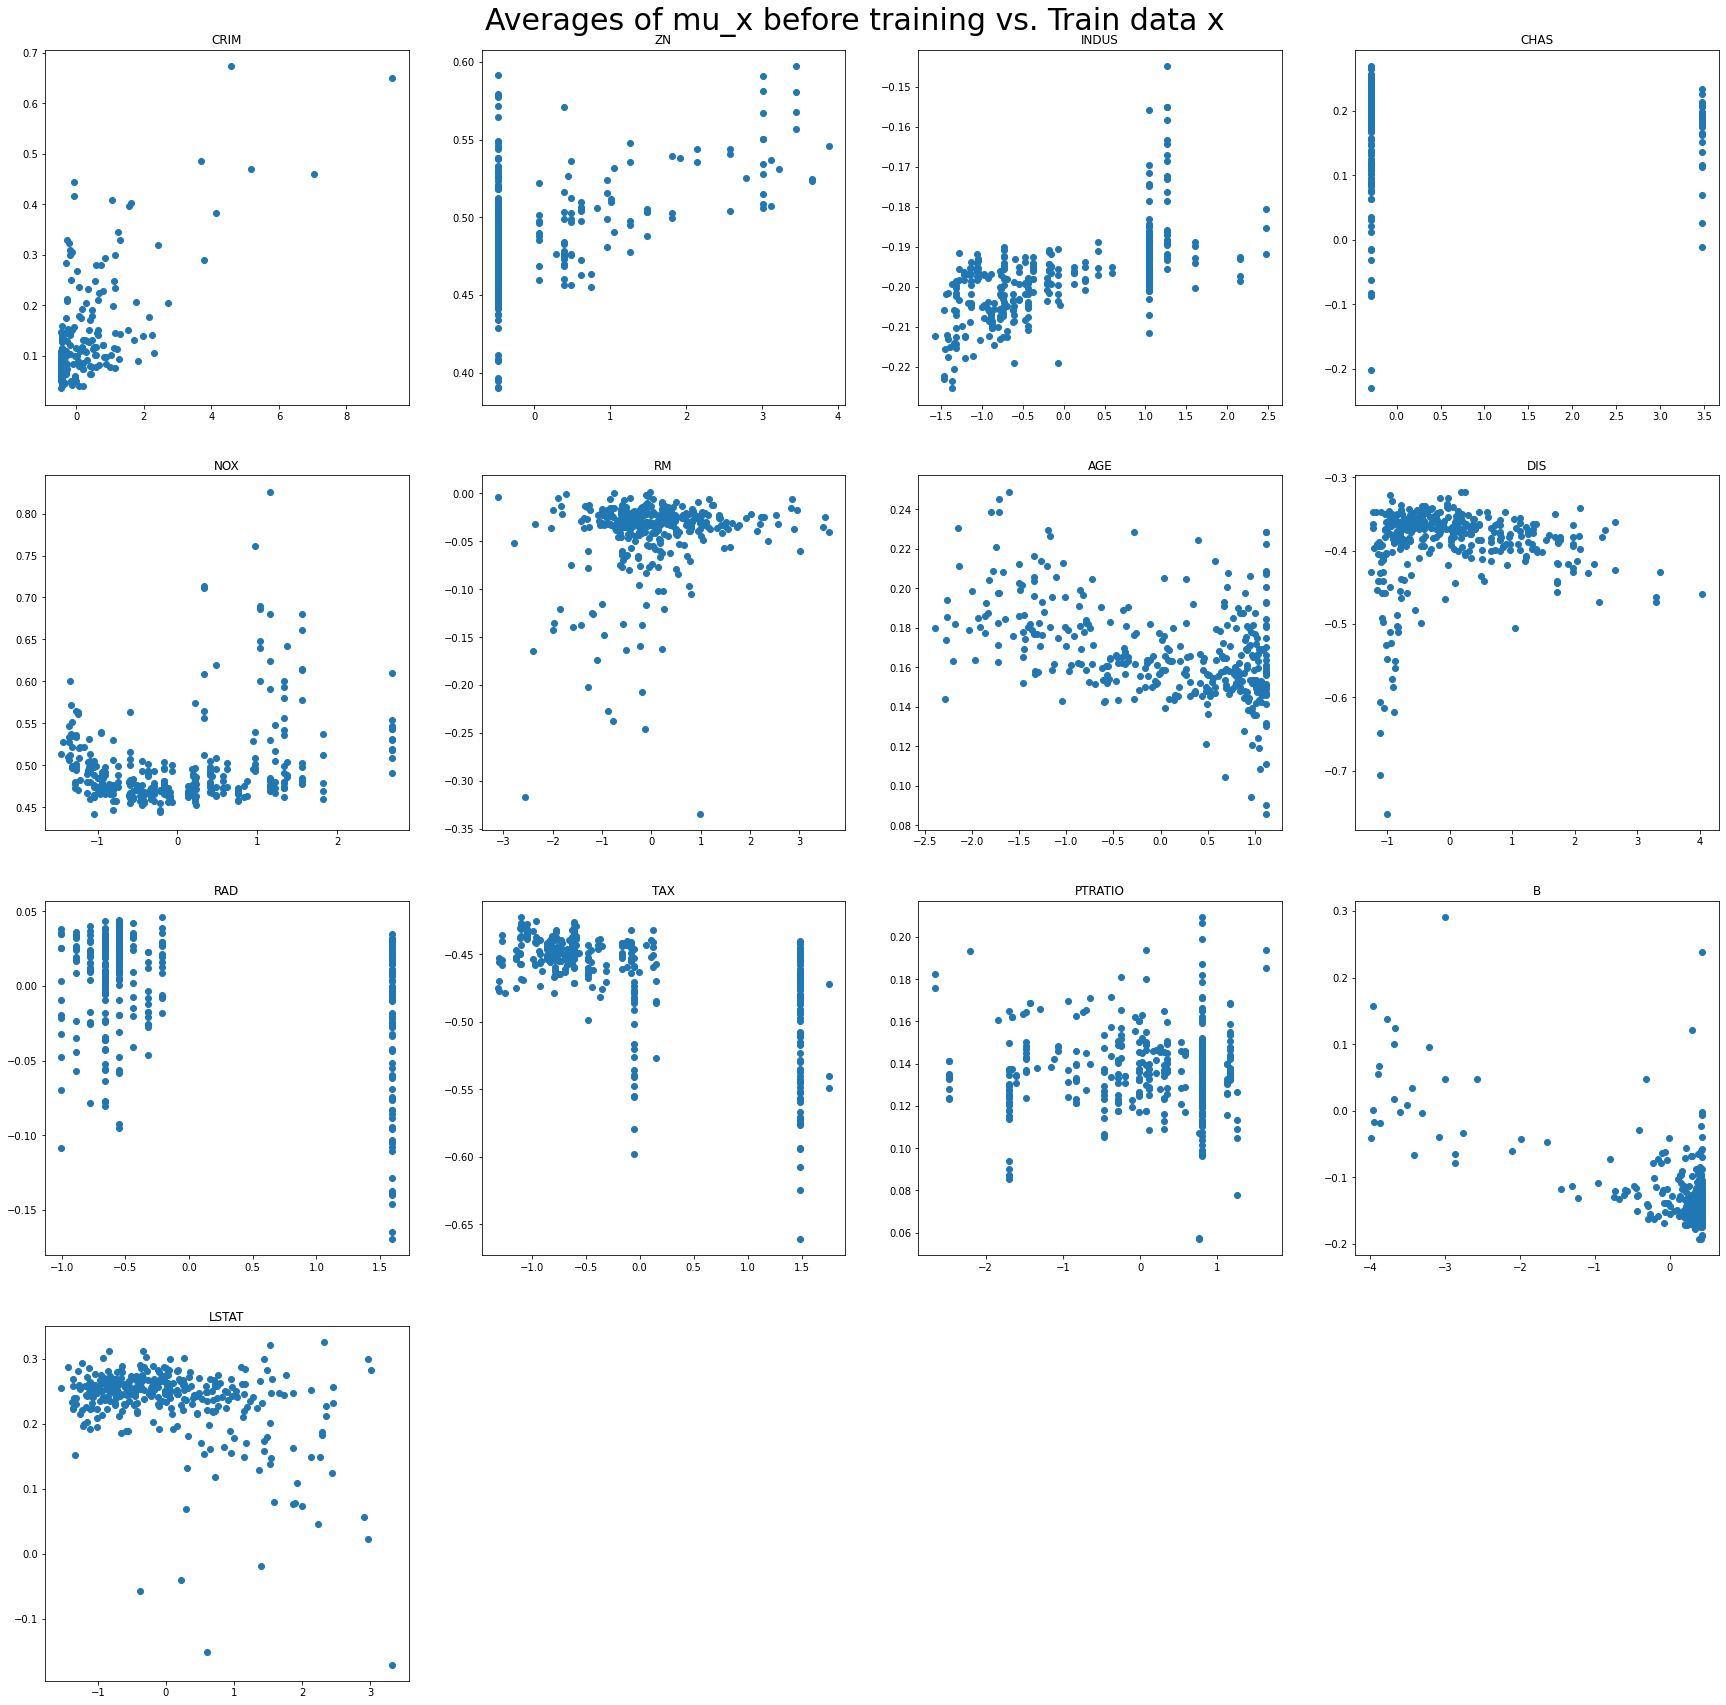

In [8]:
avg_mu_x = avg_mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
#         axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
#         axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [9]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)

In [10]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [11]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [12]:
train_loss_avg = []
test_losses = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
#     
    for x in train_iter: 
#         x = x.type(torch.float64)
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        
        mu_x, std_x = dec(z_samples)
        
        # Loss
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward 
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    scheduler.step()
    
    # Test 
    mu_z, std_z = enc(X_test)
    eps = torch.randn_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)

    mu_x, std_x = dec(z_samples)

    # Loss
    test_loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, X_test)
    
    test_losses.append(test_loss)
    
    
    print("Epoch [%d / %d] average loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1]))

Epoch [1 / 1000] average loss: 21.433944
Epoch [2 / 1000] average loss: 19.902341
Epoch [3 / 1000] average loss: 19.230913
Epoch [4 / 1000] average loss: 19.195026
Epoch [5 / 1000] average loss: 18.782868
Epoch [6 / 1000] average loss: 18.664687
Epoch [7 / 1000] average loss: 18.539393
Epoch [8 / 1000] average loss: 18.443291
Epoch [9 / 1000] average loss: 18.387114
Epoch [10 / 1000] average loss: 18.343403
Epoch [11 / 1000] average loss: 18.139450
Epoch [12 / 1000] average loss: 17.865558
Epoch [13 / 1000] average loss: 17.704559
Epoch [14 / 1000] average loss: 16.974858
Epoch [15 / 1000] average loss: 16.251354
Epoch [16 / 1000] average loss: 15.689500
Epoch [17 / 1000] average loss: 14.959460
Epoch [18 / 1000] average loss: 14.455972
Epoch [19 / 1000] average loss: 13.667140
Epoch [20 / 1000] average loss: 13.217523
Epoch [21 / 1000] average loss: 12.512290
Epoch [22 / 1000] average loss: 12.093962
Epoch [23 / 1000] average loss: 11.509335
Epoch [24 / 1000] average loss: 11.009712
E

Epoch [204 / 1000] average loss: 2.202402
Epoch [205 / 1000] average loss: 2.709865
Epoch [206 / 1000] average loss: 2.975514
Epoch [207 / 1000] average loss: 2.247734
Epoch [208 / 1000] average loss: 2.207866
Epoch [209 / 1000] average loss: 1.949166
Epoch [210 / 1000] average loss: 1.572403
Epoch [211 / 1000] average loss: 1.506117
Epoch [212 / 1000] average loss: 2.027126
Epoch [213 / 1000] average loss: 1.579338
Epoch [214 / 1000] average loss: 1.375633
Epoch [215 / 1000] average loss: 1.352528
Epoch [216 / 1000] average loss: 2.382841
Epoch [217 / 1000] average loss: 2.852500
Epoch [218 / 1000] average loss: 2.671771
Epoch [219 / 1000] average loss: 2.418580
Epoch [220 / 1000] average loss: 2.025894
Epoch [221 / 1000] average loss: 1.758722
Epoch [222 / 1000] average loss: 1.465017
Epoch [223 / 1000] average loss: 1.237221
Epoch [224 / 1000] average loss: 1.386602
Epoch [225 / 1000] average loss: 1.482056
Epoch [226 / 1000] average loss: 2.516945
Epoch [227 / 1000] average loss: 2

Epoch [408 / 1000] average loss: 1.425398
Epoch [409 / 1000] average loss: 1.355992
Epoch [410 / 1000] average loss: 1.468300
Epoch [411 / 1000] average loss: 1.836410
Epoch [412 / 1000] average loss: 1.768219
Epoch [413 / 1000] average loss: 1.725110
Epoch [414 / 1000] average loss: 1.266154
Epoch [415 / 1000] average loss: 1.141368
Epoch [416 / 1000] average loss: 0.836763
Epoch [417 / 1000] average loss: 0.952874
Epoch [418 / 1000] average loss: 1.241758
Epoch [419 / 1000] average loss: 1.641592
Epoch [420 / 1000] average loss: 1.966106
Epoch [421 / 1000] average loss: 1.581855
Epoch [422 / 1000] average loss: 1.263992
Epoch [423 / 1000] average loss: 1.142340
Epoch [424 / 1000] average loss: 0.896572
Epoch [425 / 1000] average loss: 0.693630
Epoch [426 / 1000] average loss: 0.483622
Epoch [427 / 1000] average loss: 0.291620
Epoch [428 / 1000] average loss: 0.255870
Epoch [429 / 1000] average loss: 1.793138
Epoch [430 / 1000] average loss: 2.259371
Epoch [431 / 1000] average loss: 2

Epoch [610 / 1000] average loss: -2.106463
Epoch [611 / 1000] average loss: -1.348702
Epoch [612 / 1000] average loss: -0.939486
Epoch [613 / 1000] average loss: -1.450823
Epoch [614 / 1000] average loss: -1.740401
Epoch [615 / 1000] average loss: -1.763818
Epoch [616 / 1000] average loss: -1.993594
Epoch [617 / 1000] average loss: -2.138108
Epoch [618 / 1000] average loss: -2.303123
Epoch [619 / 1000] average loss: -2.329911
Epoch [620 / 1000] average loss: -2.346498
Epoch [621 / 1000] average loss: -2.317464
Epoch [622 / 1000] average loss: -2.401802
Epoch [623 / 1000] average loss: -2.507792
Epoch [624 / 1000] average loss: -2.470359
Epoch [625 / 1000] average loss: -2.360943
Epoch [626 / 1000] average loss: -2.417253
Epoch [627 / 1000] average loss: -2.543885
Epoch [628 / 1000] average loss: -2.500652
Epoch [629 / 1000] average loss: -2.543837
Epoch [630 / 1000] average loss: -2.349670
Epoch [631 / 1000] average loss: -2.264724
Epoch [632 / 1000] average loss: -2.341804
Epoch [633 

Epoch [809 / 1000] average loss: -3.822433
Epoch [810 / 1000] average loss: -1.591389
Epoch [811 / 1000] average loss: -0.736134
Epoch [812 / 1000] average loss: -1.227745
Epoch [813 / 1000] average loss: -1.711538
Epoch [814 / 1000] average loss: -1.440388
Epoch [815 / 1000] average loss: -2.238015
Epoch [816 / 1000] average loss: -3.050677
Epoch [817 / 1000] average loss: -3.102276
Epoch [818 / 1000] average loss: -3.369633
Epoch [819 / 1000] average loss: -3.451202
Epoch [820 / 1000] average loss: -3.647606
Epoch [821 / 1000] average loss: -3.733292
Epoch [822 / 1000] average loss: -3.781623
Epoch [823 / 1000] average loss: -3.735696
Epoch [824 / 1000] average loss: -3.907858
Epoch [825 / 1000] average loss: -3.812888
Epoch [826 / 1000] average loss: -3.809087
Epoch [827 / 1000] average loss: -3.821472
Epoch [828 / 1000] average loss: -3.923658
Epoch [829 / 1000] average loss: -4.022591
Epoch [830 / 1000] average loss: -4.081392
Epoch [831 / 1000] average loss: -3.908847
Epoch [832 

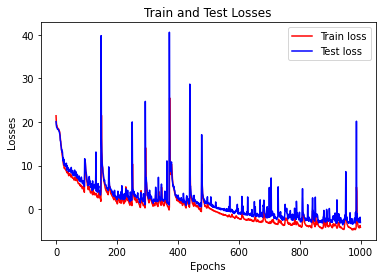

In [20]:
plt.plot(train_loss_avg, "r")
plt.plot(test_losses, "b")
plt.legend(["Train loss", "Test loss"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
# plt.ylim(0, 50)
plt.title("Train and Test Losses")
plt.show()

In [14]:
avg_mu_x_trained = torch.zeros(X_train.shape)

for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_trained += mu_x
    mu_x = torch.zeros(mu_x.shape)
avg_mu_x_trained /= 100
avg_mu_x_trained.shape

torch.Size([354, 13])

## Evaluation

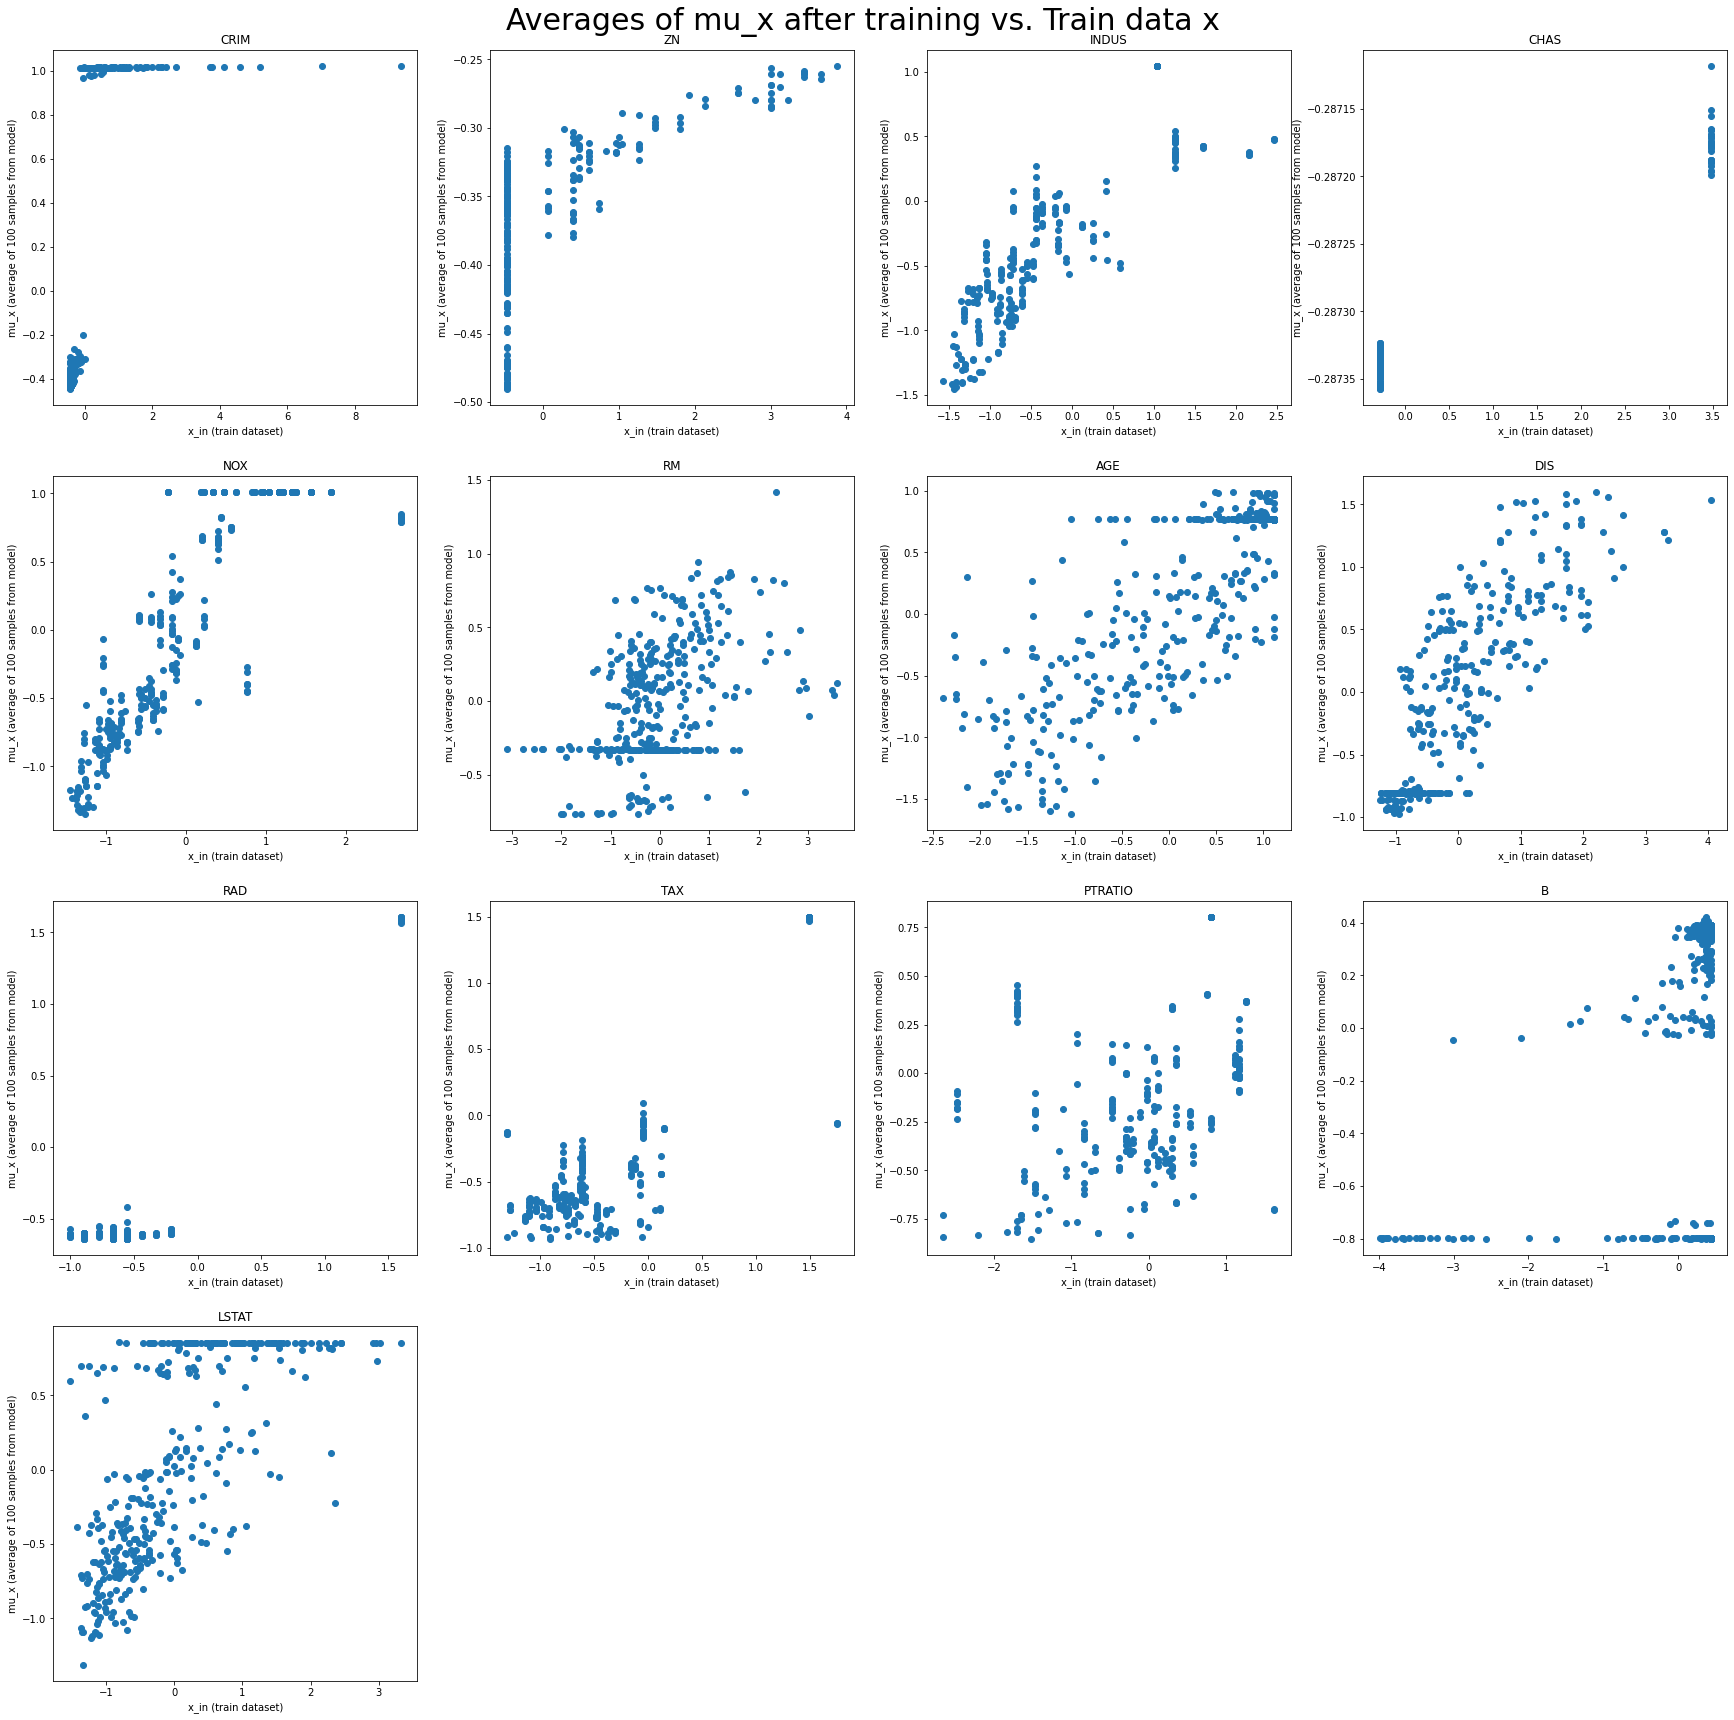

In [15]:
avg_mu_x_trained = avg_mu_x_trained.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x_trained[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [16]:
avg_mu_x_test = torch.zeros(X_test.shape)

for i in range(100):
    mu_z, std_z = enc(X_test)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_test += mu_x
    mu_x = torch.zeros(mu_x.shape)
avg_mu_x_test /= 100
avg_mu_x_test.shape

torch.Size([152, 13])

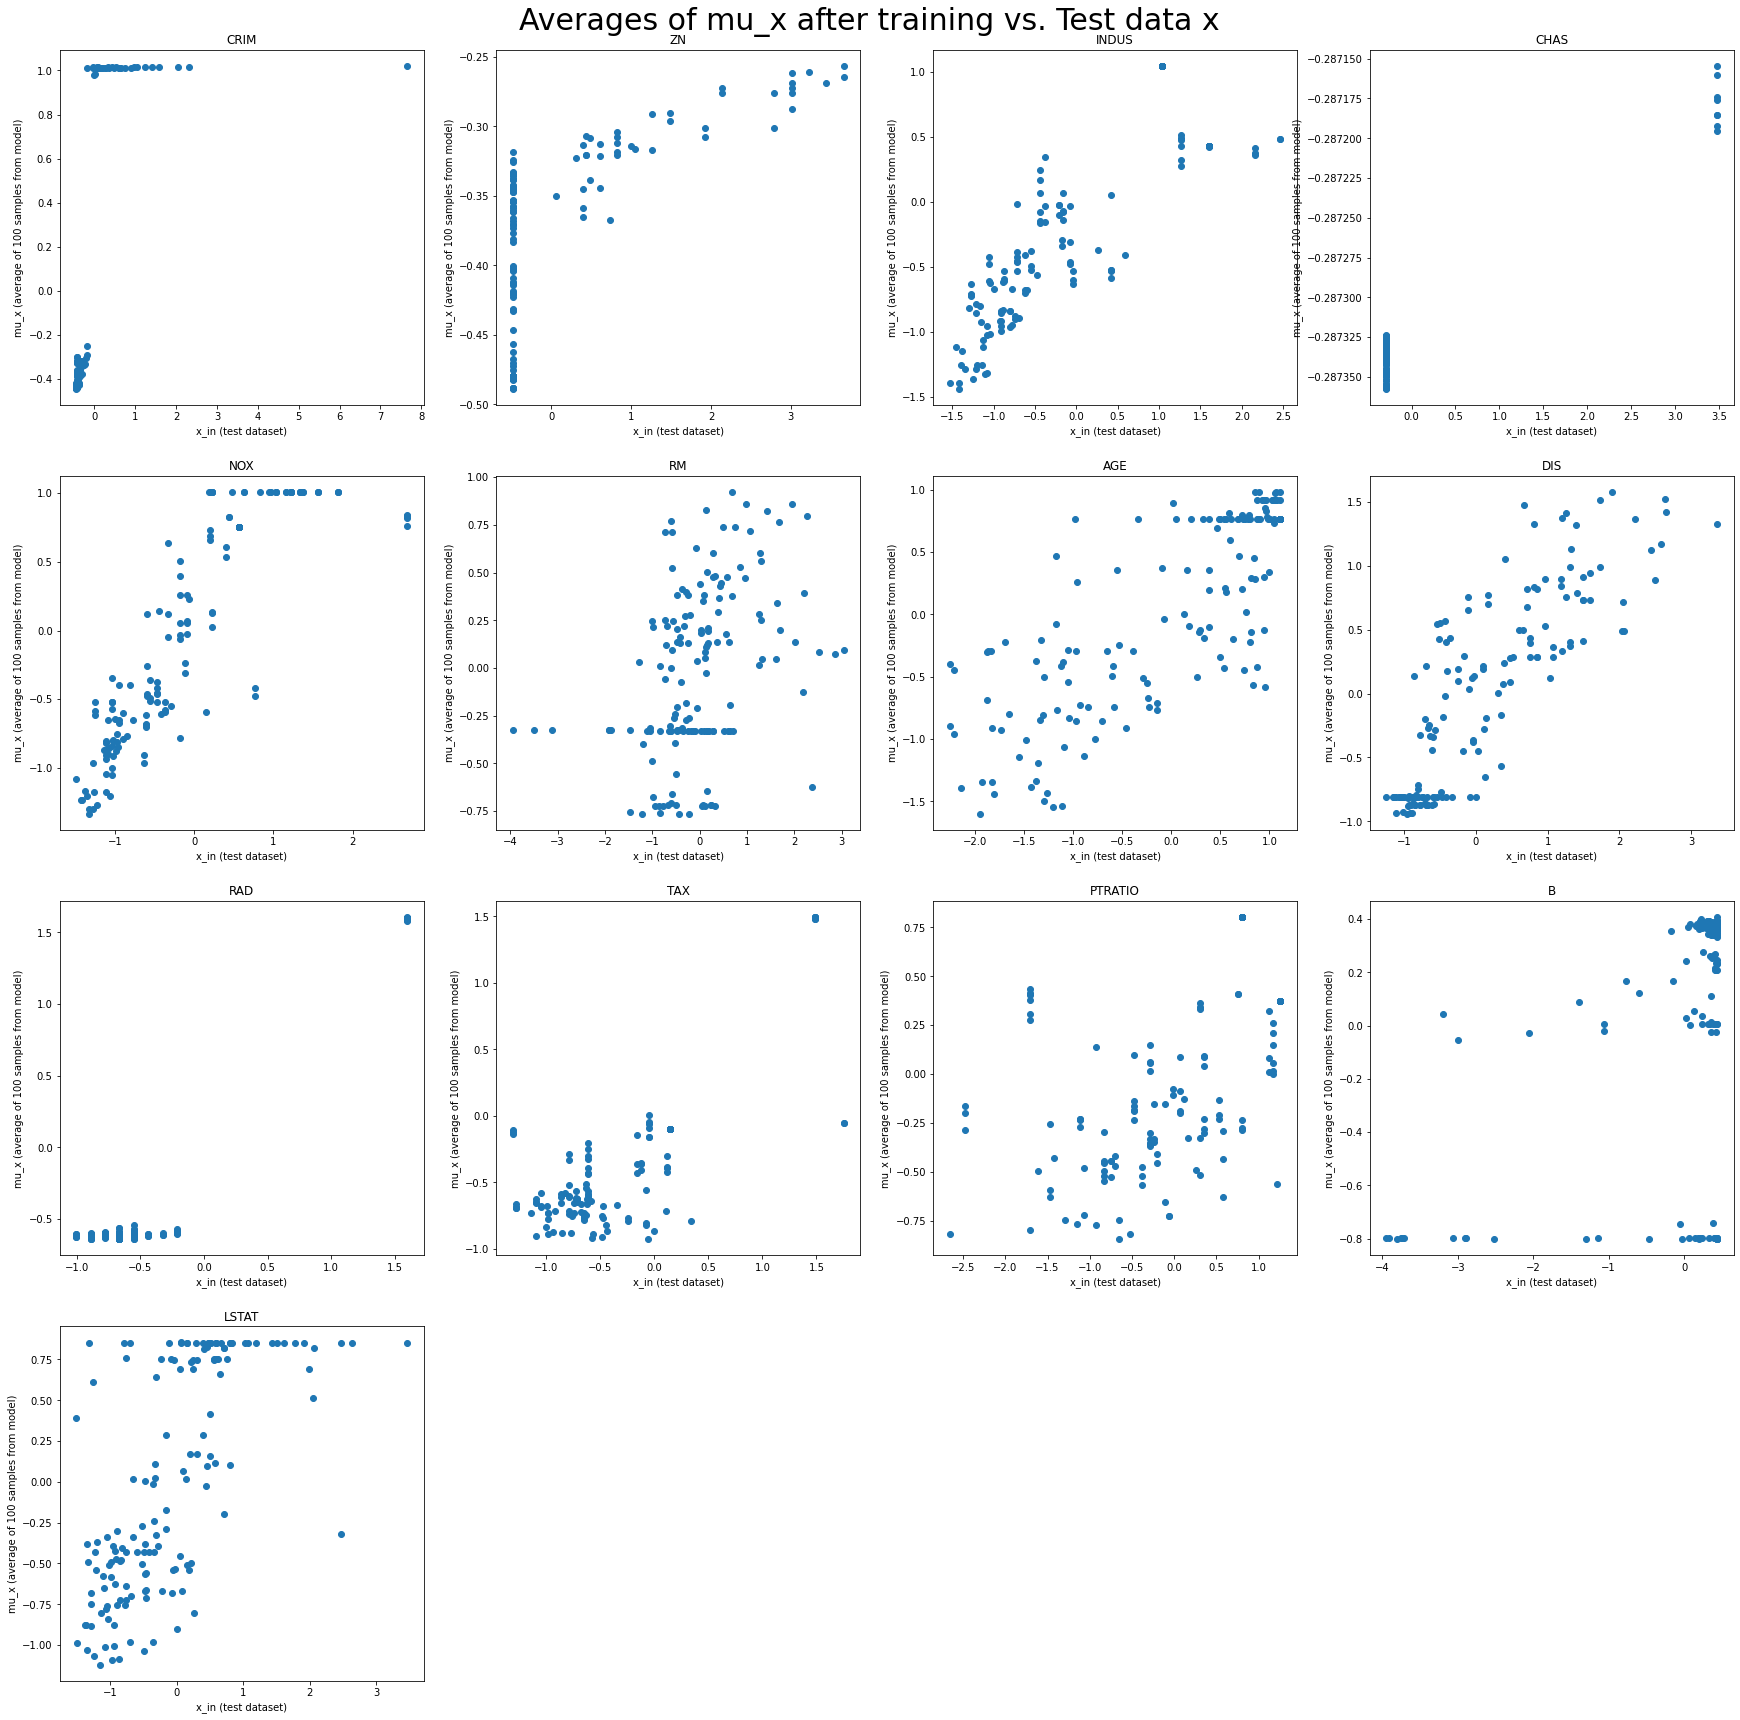

In [17]:
avg_mu_x_test = avg_mu_x_test.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_test[:,i*4+j], avg_mu_x_test[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (test dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x after training vs. Test data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [18]:
# avg_mu_x = torch.zeros(X_train.shape)
# for i in range(100):
p_z = torch.distributions.Normal(0, 1)
z = p_z.sample((200, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

torch.Size([200, 13])


In [19]:
# mu_x = mu_x.detach().numpy()
corr_eval = np.corrcoef(mu_x, rowvar=False)
print(mu_x.shape)
import seaborn as sns
with sns.axes_style("white"):
    ax = sns.heatmap(corr_eval, vmax=.3, square=True,  cmap="BuPu")
    plt.title("Correlation on Prior Sampled")
    plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
corr_test = np.corrcoef(X_test, rowvar=False)
print(mu_x.shape)
import seaborn as sns
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, vmax=.3, square=True,  cmap="BuPu")
    plt.title("Correlation on Test Data")
    plt.show()

In [ ]:
corr_train = np.corrcoef(X_train, rowvar=False)
print(mu_x.shape)
import seaborn as s
with sns.axes_style("white"):
    ax = sns.heatmap(corr_train, vmax=.3, square=True,  cmap="BuPu")
    plt.title("Correlation on Train Data")
    plt.show()